## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang
### Exploratory Data Analysis

## Load the Data 

We are trying to use a dataset of intake information including breed, color, sex, and age from the Austin Animal Center

In [8]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [9]:
from sklearn.cross_validation import train_test_split
import re

# Load the data
data = pd.read_csv('../data/train.csv')
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['TotalOutcome'] = data['OutcomeType'].map(str) + "-" + data['OutcomeSubtype']
data['Female'] = 'Female' in data['SexuponOutcome']
del data['AnimalID']
data['AgeuponOutcome'].fillna('', inplace = True)


Convert the age from year, months, week, day to the same unit

In [10]:
def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)

Separating the animal gender and intactness from SexuponOutcome

In [11]:
def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

Define a mixed breed function that contains infomation on whether the animal is a mix or not. 
Also check if the animal was given a name or not

In [12]:
def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)


def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

Change all breed and color strings so that they are ordered consistently, e.g.  all "brown/black" and "black/brown" should become "black, brown"

In [13]:
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)

# Set target and predictors
target = 'OutcomeType'
predictors = [c for c in data.columns if not c == target]

# Train/test split
X = data[predictors]
y = data[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

Take a look at the first few rows of the data.

In [4]:
data.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,TotalOutcome,Female,ConvertedAge,Intact,MixedBreed,Named,OrderedColor,OrderedBreed
0,Hambone,2/12/2014 18:22,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner-,Male,52.0,Spayed/Neutered,Mixed Breed,Named,Brown White,Shetland-Sheepdog-Mix
1,Emily,10/13/2013 12:44,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia-Suffering,Female,52.0,Spayed/Neutered,Mixed Breed,Named,Cream-Tabby,Domestic-Shorthair-Mix
2,Pearce,1/31/2015 12:28,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption-Foster,Male,104.0,Spayed/Neutered,Mixed Breed,Named,Blue White,Pit-Bull-Mix
3,NaN,7/11/2014 19:09,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer-Partner,Male,3.0,Intact,Mixed Breed,Unnamed,Blue-Cream,Domestic-Shorthair-Mix
4,NaN,11/15/2013 12:52,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer-Partner,Male,104.0,Spayed/Neutered,Known Breed Combo,Unnamed,Tan,Lhasa-Apso Miniature-Poodle


## EDA

We will go over: 
- Distribution of each feature
- Missing values
- Distribution of target
- Relationships between features
- Other idiosyncracies

A quick look at the variables

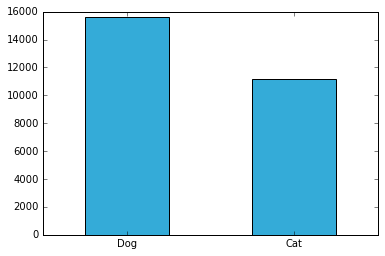

In [16]:
#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [17]:
#Animal types and their outcomes 
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

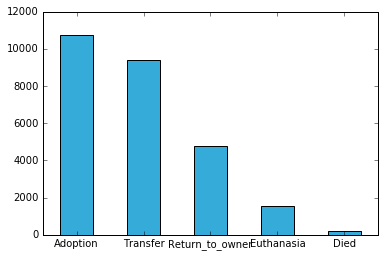

In [18]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

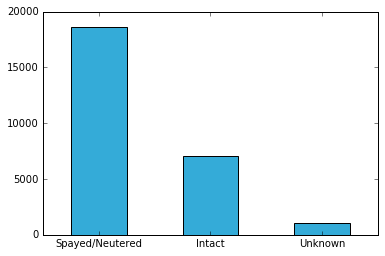

In [19]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [20]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

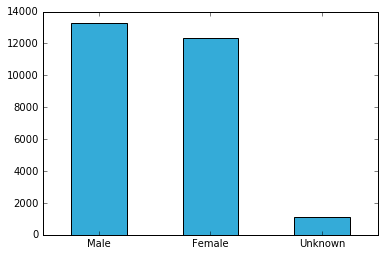

In [21]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [22]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

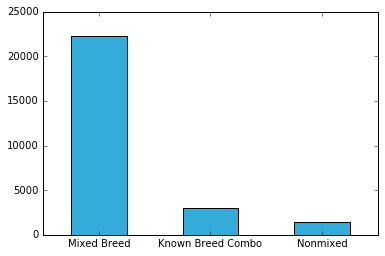

In [23]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [24]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cd0cc50>]], dtype=object)

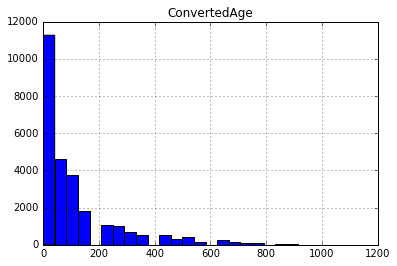

In [26]:
data.hist(column="ConvertedAge", bins=25)

In [27]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

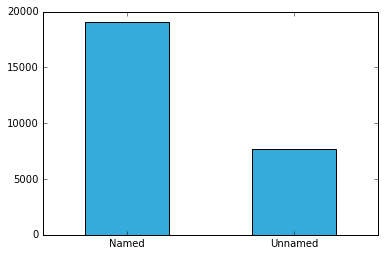

In [28]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [29]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [88]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

('Unique Colors', 275)
['Brown White' 'Cream-Tabby' 'Blue White' 'Blue-Cream' 'Tan' 'Black Tan'
 'Blue-Tabby' 'Brown-Tabby' 'Red White' 'White' 'Black' 'Silver' 'Brown'
 'Black Red' 'Cream White' 'Orange-Tabby White' 'Black White'
 'Brown-Brindle White' 'Black Brown' 'Orange-Tabby' 'Chocolate White'
 'Tan White' 'Cream-Tabby White' 'Blue' 'Calico' 'Torbie' 'Yellow'
 'Tricolor' 'Tortie' 'Blue-Tabby White' 'Gray White' 'Buff'
 'Brown-Tabby White' 'Red' 'Blue Tan' 'Seal-Point' 'Brown-Brindle' 'Gray'
 'White Yellow-Brindle' 'Fawn White' 'Flame-Point' 'Black-Tabby White'
 'Calico Tortie' 'Black Brown-Brindle' 'Silver Tan' 'Black Red-Tick'
 'Blue-Merle' 'Chocolate Tan' 'Sable' 'Brown-Merle White'
 'Brown-Tiger White' 'Liver White' 'Black Gray' 'Cream' 'Chocolate'
 'Blue-Point' 'Apricot White' 'Black Red-Merle' 'Blue-Merle White' 'Fawn'
 'Lynx-Point White' 'Black Fawn' 'Red-Tick White' 'Buff Tan'
 'Brown-Brindle Red-Tick' 'Lilac-Point' 'Buff White' 'Tortie-Point'
 'Lynx-Point' 'Tortie White' 

In [30]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

('Unique Breeds', 1143)
['Shetland-Sheepdog-Mix' 'Domestic-Shorthair-Mix' 'Pit-Bull-Mix' ...,
 'English-Bulldog French-Bulldog' 'Boxer Vizsla'
 'Australian-Kelpie German-Shepherd']


## Processing

There are a few obvious things we would like to do with this data before we start trying different models.

1. We will delete all the rows that have duplicate or useless information, such as animalID and SexuponOutcome.

2. As with most data we will come across, this one had data that was either missing or had literal values of ‘Unknown’. In general we dealt with this data by replacing it with blank strings. 


## Try some different models